In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2 

In [2]:
import json, pdb
import numpy as np
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from pathlib import Path
from collections import defaultdict
from keras import backend as K
import matplotlib.pyplot as plt
import time
import pandas as pd
import os
import math
import logging
from itertools import product
import warnings

Using TensorFlow backend.


In [3]:
import sys
sys.path.insert(0, 'data_generator_object_detection_2d')
from object_detection_2d_data_generator import DataGenerator
from transformations.object_detection_2d_geometric_ops import Resize
from transformations.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_augmentation_chains.data_augmentation_chain_original_ssd import SSDDataAugmentation
from misc_utils.object_detection_2d_misc_utils import apply_inverse_transforms

In [4]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logging.getLogger('PIL').setLevel(logging.WARNING) #PIL complains during debug, set it for critical info

# Using the Data Generator

In [5]:
train_dataset = DataGenerator()
val_dataset = DataGenerator()

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# TODO: Set the paths to the datasets here.

# The directories that contain the images.
VOC_2007_images_dir      = os.path.join(os.getcwd(), 'pascal/VOCdevkit/VOC2007/JPEGImages/')
VOC_2012_images_dir      = os.path.join(os.getcwd(), 'pascal/VOCdevkit/VOC2012/JPEGImages/')

# The directories that contain the annotations.
VOC_2007_annotations_dir      = os.path.join(os.getcwd(), 'pascal/VOCdevkit/VOC2007/Annotations/')
VOC_2012_annotations_dir      = os.path.join(os.getcwd(), 'pascal/VOCdevkit/VOC2012/Annotations/')

# The paths to the image sets.
VOC_2007_train_image_set_filename    = os.path.join(os.getcwd(), 'pascal/VOCdevkit/VOC2007/ImageSets/Main/train.txt')
VOC_2012_train_image_set_filename    = os.path.join(os.getcwd(), 'pascal/VOCdevkit/VOC2012/ImageSets/Main/train.txt')
VOC_2007_val_image_set_filename      = os.path.join(os.getcwd(), 'pascal/VOCdevkit/VOC2007/ImageSets/Main/val.txt')
VOC_2012_val_image_set_filename      = os.path.join(os.getcwd(), 'pascal/VOCdevkit/VOC2012/ImageSets/Main/val.txt')
VOC_2007_trainval_image_set_filename = os.path.join(os.getcwd(), 'pascal/VOCdevkit/VOC2007/ImageSets/Main/trainval.txt')
VOC_2012_trainval_image_set_filename = os.path.join(os.getcwd(), 'pascal/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt')
VOC_2007_test_image_set_filename     = os.path.join(os.getcwd(), 'pascal/VOCdevkit/VOC2007/ImageSets/Main/test.txt')

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir, 
                                     VOC_2012_images_dir],
                        image_set_filenames=[VOC_2007_trainval_image_set_filename,
                                             VOC_2012_trainval_image_set_filename],
                        annotations_dirs=[VOC_2007_annotations_dir,
                                          VOC_2012_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)


val_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                      image_set_filenames=[VOC_2007_test_image_set_filename],
                      annotations_dirs=[VOC_2007_annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)


test.txt: 100%|██████████| 4952/4952 [00:09<00:00, 511.24it/s]


## Data Augmentation

In [6]:
img_height = 300
img_width = 300
mean_color = [123, 117, 104]

ssd_data_augmentation = SSDDataAugmentation(img_height=img_height, img_width=img_width, background=mean_color)

In [7]:
batch_size = 2
train_generator = train_dataset.generate(batch_size=batch_size,
                                 shuffle=False,
                                 transformations=[ssd_data_augmentation],
                                 label_encoder=None,
                                 returns = {
                                     'processed_images',
                                     'processed_labels',
                                     'filenames',
                                     'original_images',
                                     'original_labels'
                                 },
                                  keep_images_without_gt=False
                
                                 )

In [8]:
processed_images, processed_annotations, filenames, original_images, original_annotations = next(train_generator)

i = 0 # Which batch item to look at 

print("Image:", filenames[i])
print()
print("Original ground truth boxes:\n")
print(np.array(original_annotations[i]))

Image: /data1/mikeliao/classes/fastai/courses/dl2/mikeliao-ssd/pascal/VOCdevkit/VOC2007/JPEGImages/000005.jpg

Original ground truth boxes:

[[  9 263 211 324 339]
 [  9 165 264 253 372]
 [  9   5 244  67 374]
 [  9 241 194 295 299]
 [  9 277 186 312 220]]


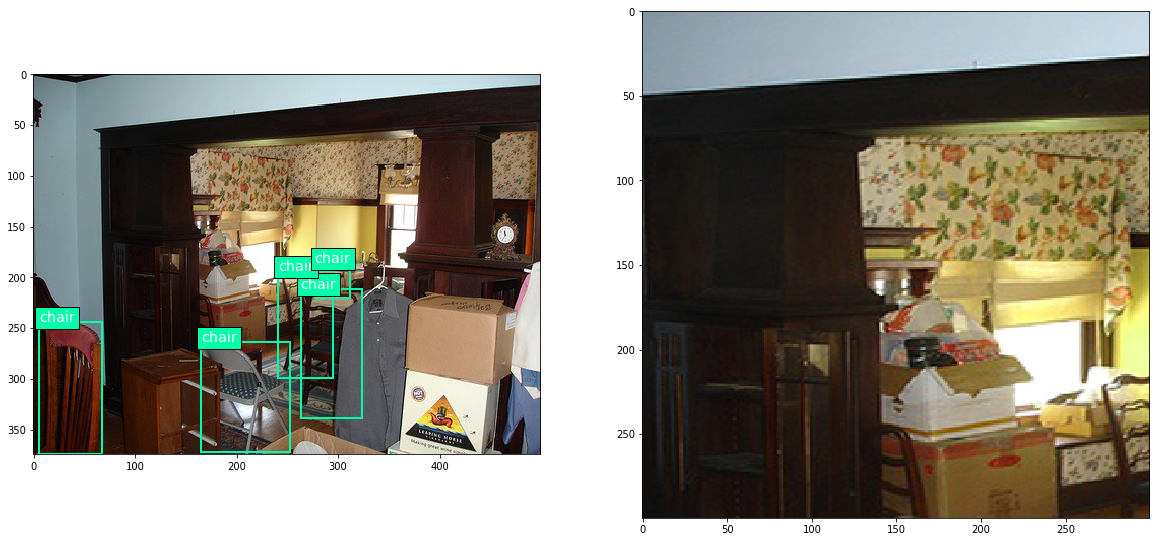

In [9]:
colors = plt.cm.hsv(np.linspace(0, 1, len(classes))).tolist() # Set the colors for the bounding boxes

fig, cell = plt.subplots(1, 2, figsize=(20,16))
cell[0].imshow(original_images[i])
cell[1].imshow(processed_images[i])

for box in original_annotations[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    color = colors[int(box[0])]
    label = '{}'.format(classes[int(box[0])])
    cell[0].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    cell[0].text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    
for box in processed_annotations[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    color = colors[int(box[0])]
    label = '{}'.format(classes[int(box[0])])
    cell[1].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    cell[1].text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

# Build the Anchor Boxes for each Layer

Assume that I'm predicting using conv4_3, conv7, conv8_2, conv9_2,
This means that I have
m=4 prediction feature maps


In [10]:
feature_map_size = [37, 18, 9, 5]
prior_boxes = {}
s_min, s_max = 0.2, 0.9
aspect_ratios = [1, 2, 3, 1/2, 1/3]

In [11]:
default_boxes = []
for idx, val in enumerate(feature_map_size):
    s_k = s_min + ((s_max - s_min) / len(feature_map_size)) * (idx - 1)
    s_kplus1 =  s_min + ((s_max - s_min) / len(feature_map_size)) * (idx + 1 - 1)

    #add boxes for scale of 1
    s_prime = math.sqrt(s_k * s_kplus1)
    
    f_k = feature_map_size[idx]
    for i, j in product(range(val), repeat = 2):
        #The centers
        c_x = (i + 0.5) / f_k
        c_y = (j + 0.5) / f_k
        
        #add the sprime scale of 1
        width_1 = s_prime
        height_1 = s_prime
        
        default_boxes.append([c_x, c_y, width_1, height_1])
        for ar in aspect_ratios:
            width = s_k * math.sqrt(ar)
            height = s_k / math.sqrt(ar)
            default_boxes.append([c_x, c_y, width, height])
 

        


In [12]:
default_boxes = np.array(default_boxes)

In [13]:
default_boxes.shape

(10794, 4)

### Build the SSD Network

In [14]:
num_class = 21
num_boxes = 4
k = 6 #We build 4 anchor boxes for each, this means conv4_3 will have alot of boxes :(
boxes = k *  num_boxes
classes = k * num_class

In [15]:
def gt_offsets(priors_select, gt_bbox):
    '''
    This function takes the offsets of the gt_bbox relative to the prior_boxes.
    The offsets are from center off form and follow from the definition defined in SSD.
    offset_width = log(gt_width / prior_width)
    offset_centerX = (gt_centerX - prior_centerX) / prior_width
    
    Arguments:
        p_boxes: #priors x [centerX, centerY, width, height]
        p_boxes_indices: #priors x [index]
        gt_bbox: #gt_bbox x [centerX, centerY, width, height]
    Return:
        Offsets: #gt_bbox x [offsetX, offsetY, offsetWidth, offsetHeight]
    '''
    cX, cY, width, height = 0, 1, 2, 3

    offsetX = (gt_bbox[:, [cX]] - priors_select[:, [cX]]) / priors_select[:, [width]]
    offsetY = (gt_bbox[:, [cY]] - priors_select[:, [cY]]) / priors_select[:, [height]]
    offsetW = np.log(gt_bbox[:, [width]] / priors_select[:, [width]])
    offsetH = np.log(gt_bbox[:, [height]] / priors_select[:, [height]])
    
    
    return_val = np.hstack((offsetX, offsetY, offsetW, offsetH))
    
    
    #logger.debug('priors select %s', priors_select)
#     logger.debug('gt pascals %s', gt_bbox)
#     logger.debug('offsets %s', return_val)
#     logger.debug('=================================')
    return return_val

In [16]:
def bb2_centeroff(bbox):
    '''
    Arguments:
        bbox: [#boxes, xmin, ymin, xmax, ymax]:
    Returns:
        centeroffset: [#boxes, centerX, centerY, width, height]
    '''
    '''
    xmin, ymin, xmax, ymax = bbox
    return [(xmin + xmax) / 2, (ymin + ymax) / 2,
                  xmax - xmin,  ymax - ymin]
    '''
    
    
    centerX = (bbox[:, 0:1] + bbox[:, 2:3]) / 2
    centerY = (bbox[:, 1:2] + bbox[:, 3:4]) / 2
    width = bbox[:, 2:3] - bbox[:, 0:1]
    height = bbox[:, 3:4] - bbox[:, 1:2]
    return np.hstack((centerX, centerY, width, height))
 

In [17]:
def center2_bb(bbox_c):
    '''
    Arguments:
        bbox_c: #boxes x [centerX, centerY, width, height]
        
    
    '''
    Xmin, Xmax = bbox_c[:, 0:1] - bbox_c[:, 2:3]/2, bbox_c[:, 0:1] + bbox_c[:, 2:3]/2
    Ymin, Ymax = bbox_c[:, 1:2] - bbox_c[:, 3:4]/2, bbox_c[:, 1:2] + bbox_c[:, 3:4]/2
    
    return_box = np.hstack((Xmin, Ymin, Xmax, Ymax))
    return np.ceil(return_box) #sometimes theres rounding errors so round to nearest inteeger
    

In [18]:
def f_s(elem):
    return np.sort(elem.flatten())

In [19]:
def iou(p_bb, gt_bb):
    '''
    TODO: Vectorize it 
    Arguments:
        prior_boxes: [#boxes, Xmin, Ymin, Xmax, Ymax]
        gt: [#gt, Xmin, Ymin, Xmax, Ymax]
    Returns:
        IOU_prior_gt: [#boxes, #gt]
    '''
    xmin = 0
    ymin = 1
    xmax = 2
    ymax = 3
    
    num_priors = p_bb.shape[0]
    num_gt = gt_bb.shape[0]

    
    #Calculate the max_xy betweeen each of the prior box, and gt_box by taking the max of the min.
    min_priors_repeated = np.tile(np.expand_dims(p_bb[:, [xmin, ymin]], axis=1), reps=(1, num_gt, 1))
    min_gt_repeated = np.tile(np.expand_dims(gt_bb[:, [xmin, ymin]], axis=0), reps=(num_priors, 1,1))
    min_xy = np.maximum(min_priors_repeated, min_gt_repeated); 
    
    #Calculate the min_xy between each each of the prior box by taking the min of x,y
    max_priors_repeated = np.tile(np.expand_dims(p_bb[:, [xmax, ymax]], axis=1), reps=(1, num_gt, 1))
    max_gt_repeated = np.tile(np.expand_dims(gt_bb[:, [xmax, ymax]], axis=0), reps=(num_priors, 1,1))
    max_xy = np.minimum(max_priors_repeated, max_gt_repeated);

    differences = np.maximum(0, max_xy - min_xy)
    intersec = differences[:, :, 0] * differences[:,:, 1]

    
    #Calculate the area of the shapes
    prior_diffX = p_bb[:, xmax] - p_bb[:, xmin];
    prior_diffY = p_bb[:, ymax] - p_bb[:, ymin]
    area_prior = np.tile(np.expand_dims(prior_diffX * prior_diffY , axis=1), reps=(1, num_gt))
    neg2 = area_prior.flatten()

    
    gt_diffX = gt_bb[:, xmax] - gt_bb[:, xmin]
    gt_diffY = gt_bb[:, ymax] - gt_bb[:, ymin]
    area_gt = np.tile(np.expand_dims(gt_diffX * gt_diffY, axis=0), reps=(num_priors, 1))
    negatives = area_gt.flatten()

    union = area_gt + area_prior - intersec

    result = intersec / union
    
    result[result < 0] = 0
     

        
    return result

In [20]:
IMG_SIZE = 300.0
pascal_priors = center2_bb(default_boxes * IMG_SIZE); pascal_priors
centeroff_priors = (default_boxes * IMG_SIZE)

In [21]:
batch_size = 2
train_generator = train_dataset.generate(batch_size=batch_size,
                                 shuffle=False,
                                 transformations=[ssd_data_augmentation],
                                 label_encoder=None,
                                 returns = {
                                     'processed_images',
                                     'processed_labels',
                                 },
                                  keep_images_without_gt=False
                
                                 )

In [22]:
def match(iou_values, gt, idx, locs, confs, centeroff_priors):
    '''
    Arguments:
        iou_values: [#boxes, #gt]
        gt: #gt x [label, centerX, centerY, width, height]
        locs: bz x #boxes x 20
    Return:
        iou_values: [#boxes]
    '''
    threshold = 0.5
    #Initialize empty arrays for 
    tmp_locs = np.full((iou_values.shape[0], 4), -20000000000)
    #tmp_confs = np.full((iou_values.shape[0]), np.inf, dtype='int')

#     tmp_locs = np.zeros((iou_values.shape[0], 4)) #best locations bounding boxes for each
    tmp_confs = np.zeros(iou_values.shape[0], dtype='int')
    
    
    #We begin by matching each ground truth box to the default box with the best jaccard overlap
    best_for_gt_idx = np.argmax(iou_values, axis=0) #returns 1 x #num_gt
    idx_gt = np.indices(best_for_gt_idx.shape) #get indices for advanced indexing into best amax
    best_for_gt_vals = iou_values[best_for_gt_idx, idx_gt] #retursn 1 x #num_gt


    gt_best = gt[idx_gt[0]][:, 1:]
    offsets_best = gt_offsets(centeroff_priors[best_for_gt_idx], gt_best)
    tmp_locs[best_for_gt_idx] = offsets_best
    tmp_confs[best_for_gt_idx] = gt[idx_gt[0]][:, 0]
    
   
    
    #We then match default boxes to any ground truth with jaccard overlap higher than a threshold
    #Then out of these indices of prior boxes, we filter for the max  
    best_for_box_idx = np.argmax(iou_values, axis=1) #returns 1 x #num_priors
    idx_box = np.indices(best_for_box_idx.shape)
    best_for_box_vals = iou_values[idx_box, best_for_box_idx] #returns 1 x #num_priors
    thresh_met = np.where(best_for_box_vals >= threshold)[1]
    gt_for_prior = best_for_box_idx[thresh_met]
        
        
    gt_thresh = gt[gt_for_prior][:, 1:]
    offsets_thresh = gt_offsets(centeroff_priors[thresh_met], gt_thresh)
    tmp_locs[thresh_met] = offsets_thresh
    tmp_confs[thresh_met] = gt[gt_for_prior][:, 0] 
    logger.debug('best iou vales %s', best_for_box_vals[:, thresh_met])
    logger.debug('priors select -> center %s', centeroff_priors[thresh_met])
    logger.debug('gt center %s', gt_thresh)
    logger.debug('offsets %s', offsets_thresh)
    logger.debug('=================================')
    
    
    #Take the max of any default box
    locs[idx] = tmp_locs
    confs[idx] = tmp_confs
    
    return tmp_locs, tmp_confs
    

Test whether match did a good job

In [23]:
image, label = next(train_generator)

In [24]:
gt = np.array(label)[0]

In [25]:
logger.setLevel(logging.WARNING)

In [26]:
iou_values = iou(pascal_priors, gt[:, 1:]); iou_values.shape
#This is just a debug example, locs and confs are not dicts, but lists!
tmp_locs, tmp_confs = match(iou_values,gt, 0, {}, {}, centeroff_priors) 

nonzero_confs = np.nonzero(tmp_confs); nonzero_confs

boxes_default = pascal_priors[nonzero_confs]; boxes_default

array([[ 38., 133.,  80., 218.],
       [ 42., 124.,  76., 227.],
       [ 38., 150.,  80., 235.],
       [ 42., 140.,  76., 244.],
       [ 54., 133.,  97., 218.],
       [ 58., 124.,  93., 227.],
       [ 54., 150.,  97., 235.],
       [ 58., 140.,  93., 244.]])

# Todo: FIX IOU

In [27]:
colors = plt.cm.hsv(np.linspace(0, 1, 25)).tolist(); colors[:3]

[[1.0, 0.0, 0.0, 1.0],
 [1.0, 0.2316178786767022, 0.0, 1.0],
 [1.0, 0.48639754522107453, 0.0, 1.0]]

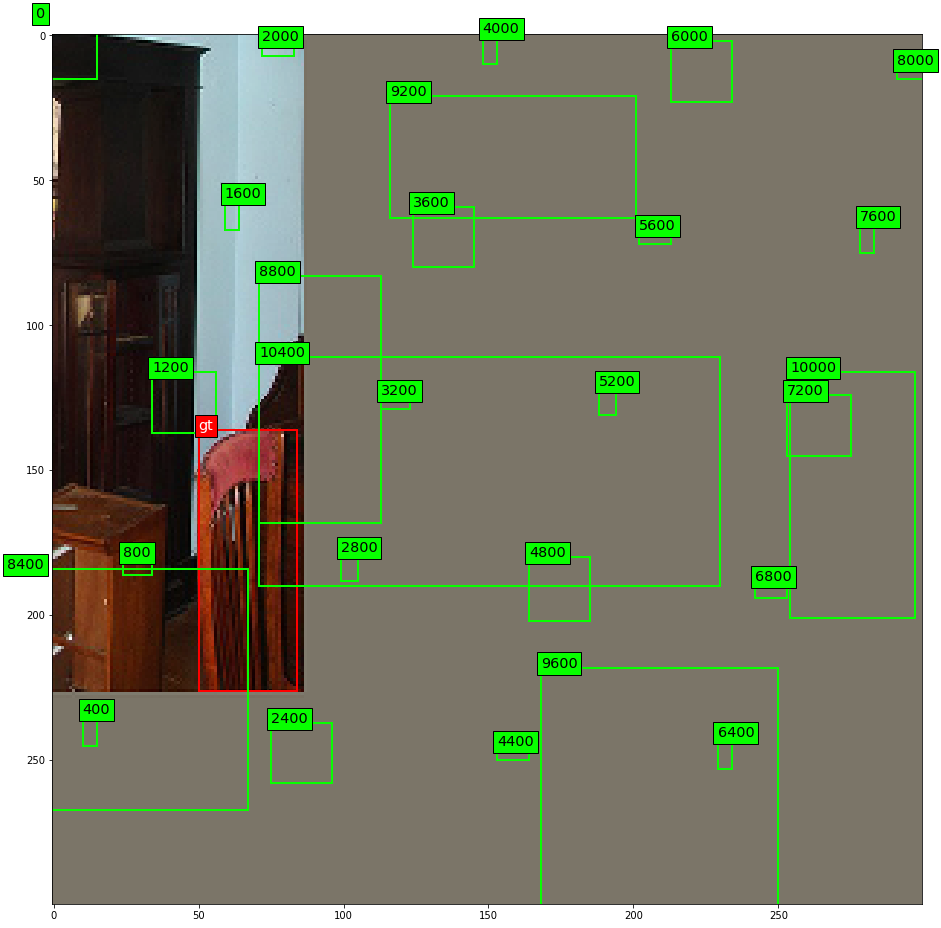

In [28]:
fig, cell = plt.subplots(1, figsize=(20,16))
cell.imshow(image[0])

for box in gt:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    color = colors[0]
    cell.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    cell.text(xmin, ymin, 'gt', size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})


step = 400
for idx, box in enumerate(pascal_priors[::step]):
    xmin = box[0]
    ymin = box[1]
    xmax = box[2]
    ymax = box[3]
    color = colors[8]
    cell.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    cell.text(xmin, ymin, idx*step, size='x-large', color='black', bbox={'facecolor':color, 'alpha':1.0})


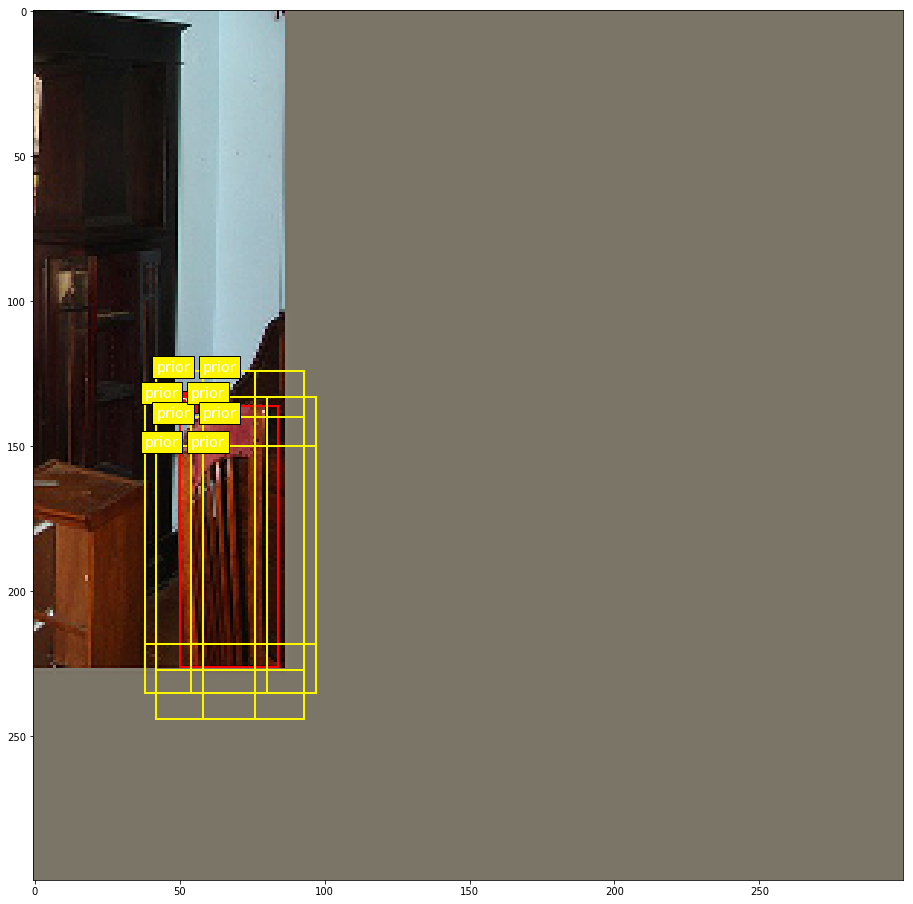

In [29]:
fig, cell = plt.subplots(1, figsize=(20,16))
cell.imshow(image[0])

for box in gt:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    color = colors[0]
    cell.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    cell.text(xmin, ymin, 'gt', size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

    
for box in boxes_default:
    xmin = box[0]
    ymin = box[1]
    xmax = box[2]
    ymax = box[3]
    color = colors[4]
    cell.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    cell.text(xmin, ymin, 'prior', size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})


The Custom Multi Loss needs to include both the localization loss and the confidence loss


In [30]:
def one_hot(target, num_classes=21):
    return np.eye(num_classes)[target]

In [31]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Concatenate, Flatten, Reshape, Activation, Lambda
from keras.regularizers import l2


reg = 0.0005

subtract_mean=[123, 117, 104]

def input_mean_normalization(tensor):
    return tensor - np.array(subtract_mean)

img_height, img_width, img_channels = 300, 300, 3

class SSD_Network:
    def __init__(self):
        x = Input(shape=(img_height, img_width, img_channels))
        x_mean_sub = Lambda(input_mean_normalization, 
                            output_shape=(img_height, img_width, img_channels),
                            name='input_mean_normalization')(x)
        
        
        base_model = VGG16(input_tensor=x_mean_sub,
                           input_shape=(300, 300, 3), 
                           weights='imagenet', include_top=False)

        
        #Train only the top layers
        #Should I really make all the base layers untrainable? conv4_3 is part of vgg...
        for layer in base_model.layers:
            layer.trainable = True

        conv4_3 = base_model.get_layer('block4_conv3').output #shape of (bs, 38, 38 512)
        preds_1_locs = Conv2D(boxes, (3, 3), padding='same',
                  kernel_initializer='he_normal', kernel_regularizer=l2(reg))(conv4_3) #n_out depends on how many boxes/scales we have at this output
        preds_1_confs = Conv2D(classes, (3, 3), padding='same',
                  kernel_initializer='he_normal', kernel_regularizer=l2(reg))(conv4_3) 


        conv5_3 = base_model.get_layer('block5_conv3').output
        conv6 = Conv2D(1024, (3, 3), padding='same', 
                       kernel_initializer='he_normal', kernel_regularizer=l2(reg))(conv5_3)  #shape of (None, None, None, 1024)
        conv7 = Conv2D(1024, (1, 1), padding='same', 
                       kernel_initializer='he_normal', kernel_regularizer=l2(reg))(conv6) #shape of (bs, 19, 19, 1024)
        preds_2_locs = Conv2D(boxes, (3,3), padding='same',
                         kernel_initializer='he_normal', kernel_regularizer=l2(reg))(conv7) #shape of 
        preds_2_confs = Conv2D(classes, (3,3), padding='same',
                         kernel_initializer='he_normal', kernel_regularizer=l2(reg))(conv7)
   
        #conv 8
        conv8_1 = Conv2D(256, (1, 1), padding='same', 
                         kernel_initializer='he_normal', kernel_regularizer=l2(reg))(conv7)
        conv8_2 = Conv2D(512, (3, 3), padding='same', strides=(2,2),
                         kernel_initializer='he_normal', kernel_regularizer=l2(reg))(conv8_1)
        preds_3_locs = Conv2D(boxes, (3,3), padding='same', 
                         kernel_initializer='he_normal', kernel_regularizer=l2(reg))(conv8_2) #shape of 
        preds_3_confs = Conv2D(classes, (3,3), padding='same', 
                         kernel_initializer='he_normal', kernel_regularizer=l2(reg))(conv8_2) #shape of 
      

        #conv 9
        conv9_1 = Conv2D(128, (1,1), padding='same',
                         kernel_initializer='he_normal', kernel_regularizer=l2(reg))(conv8_2)
        conv9_2 = Conv2D(258, (3,3), strides=(2,2), padding='same', 
                         kernel_initializer='he_normal', kernel_regularizer=l2(reg))(conv9_1)
        preds_4_locs = Conv2D(boxes, (3,3), padding='same',
                         kernel_initializer='he_normal', kernel_regularizer=l2(reg))(conv9_2) #shape of 
        preds_4_confs = Conv2D(classes, (3,3), padding='same',
                         kernel_initializer='he_normal', kernel_regularizer=l2(reg))(conv9_2) #shape of 
        
        
        #Reshape the predictions 
        preds_1_confs_rs = Reshape((-1, num_class))(preds_1_confs)
        preds_2_confs_rs = Reshape((-1, num_class))(preds_2_confs)
        preds_3_confs_rs = Reshape((-1, num_class))(preds_3_confs)
        preds_4_confs_rs = Reshape((-1, num_class))(preds_4_confs)
        
        preds_1_locs_rs = Reshape((-1, num_boxes))(preds_1_locs)
        preds_2_locs_rs = Reshape((-1, num_boxes))(preds_2_locs)
        preds_3_locs_rs = Reshape((-1, num_boxes))(preds_3_locs)
        preds_4_locs_rs = Reshape((-1, num_boxes))(preds_4_locs)
        
        
        confs_preds = Concatenate(axis=1, name='confs')([preds_1_confs_rs, preds_2_confs_rs,
                                                   preds_3_confs_rs, preds_4_confs_rs])
            
        locs_preds = Concatenate(axis=1, name='locs')([preds_1_locs_rs, preds_2_locs_rs,
                                                      preds_3_locs_rs, preds_4_locs_rs])
        
        #compute softmax 
        confs_preds_sm = Activation('softmax')(confs_preds)
        
        #add bias to to softmax
        
    
    
        preds = Concatenate(axis=2, name='predictions')([locs_preds, confs_preds_sm])
   
        
        self.model = Model(x, outputs=[preds])


In [32]:
def contains_empty_labels_or_mismatch(images, labels):
    for lbl in labels:
        if len(lbl) == 0:
            return True
    if len(labels) != len(images):
        print('len labels', len(labels))
        print('len images', len(images))
        return True
    return False

In [33]:
#use simple generator to generate an image , anchors for the model
class simple_generator:
    def __init__(self, gen, pascal_priors):
        self.gen = gen
        self.pascal_priors = pascal_priors
        self.centerOff_priors = bb2_centeroff(self.pascal_priors)
        
    def __iter__(self):
        return self

    
    def __next__(self):
        images, labels = next(self.gen)
        
        while (contains_empty_labels_or_mismatch(images, labels)): #The generator sometimes returns empty array :(
            logger.debug('contains empty labels!')
            images, labels = next(self.gen)
        
        #iterate through each of the image, labels to process them
        bz, num_priors = len(labels), self.pascal_priors.shape[0]
        #print('images shape {}, labels shape {}'.format(
            #np.array(images).shape, np.array(labels).shape))
        
        locs = np.full((bz, num_priors, 4), np.inf)
        confs = np.full((bz, num_priors), np.inf)
        template = np.full((len(labels), self.pascal_priors.shape[0], 25), np.inf)
        
        logger.debug('image shape %s', images.shape)
        logger.debug('labels %s', labels)
        for idx,lbl in enumerate(labels):
            lbl = np.array(lbl)
            cls, bbox = lbl[:, [0]], lbl[:, 1:]
            iou_values = iou(self.pascal_priors, bbox)
            
            gt_centeroff = np.hstack((cls, bb2_centeroff(bbox)))
             
            # 2) Match the ious and the priors, match puts the idx into the locs 
            tmp_locs, tmp_confs = match(iou_values, gt_centeroff, idx, locs, confs, self.centerOff_priors)
            
            template[idx, :, :4] = tmp_locs #first four are for locations
            hots = one_hot(tmp_confs, num_classes=21);
            template[idx, :, 4:25] = hots #21 classes, 20 + background class 
            
        return images, template

In [34]:
def smooth_l1(y_true, y_pred):
    """Compute L1-smooth loss.
    # Arguments
        y_true: Ground truth bounding boxes,
            tensor of shape (?, num_boxes, 4).
        y_pred: Predicted bounding boxes,
            tensor of shape (?, num_boxes, 4).
    # Returns
        l1_loss: L1-smooth loss, tensor of shape (?, num_boxes).
    # References
        https://arxiv.org/abs/1504.08083
    """
    abs_loss = tf.abs(y_true - y_pred)
    sq_loss = 0.5 * (y_true - y_pred)**2
    l1_loss = tf.where(tf.less(abs_loss, 1.0), sq_loss, abs_loss - 0.5)
    smooth_l1_loss = tf.reduce_sum(l1_loss, -1)
    return smooth_l1_loss


In [35]:
# def softmax_loss(y_true, y_pred):
#     """Compute softmax loss.
#     # Arguments
#         y_true: Ground truth targets,
#             tensor of shape (?, num_boxes, num_classes).
#         y_pred: Predicted logits,
#             tensor of shape (?, num_boxes, num_classes).
#     # Returns
#         softmax_loss: Softmax loss, tensor of shape (?, num_boxes).
#     """
#     #preds = tf.maximum(calc_softmax(y_pred), 1e-15)
#     preds = tf.maximum(y_pred, 1e-15)
#     softmax_loss = -tf.reduce_sum(y_true * tf.log(preds),
#                                   axis=-1)
    

# #     return tf.Print(softmax_loss, [softmax_loss], 'softmax_loss', summarize=1000)
#     return softmax_loss

In [36]:
def focal_loss(y_true, y_pred):
    """Compute softmax loss.
    # Arguments
        y_true: Ground truth targets,
            tensor of shape (?, num_boxes, num_classes).
        y_pred: Predicted logits,
            tensor of shape (?, num_boxes, num_classes).
    # Returns
        softmax_loss: Softmax loss, tensor of shape (?, num_boxes).
    """
    gamma = 2
    alpha = 0.25
    preds = tf.maximum(y_pred, 1e-15)
    eq = alpha * tf.pow(1 - preds, gamma) *  tf.log(preds)   
    focal_loss = -tf.reduce_sum(y_true * eq,
                                  axis=-1)
    
    return focal_loss


In [50]:
def custom_focal_loss(y_true, y_pred):
    '''
    Arguments:
        y_true (bz x #anchor boxes x 26[4 bbox + 20 classes + 1 for it matches])
        y_pred (bz x #anchor boxes x 25)
    Returns:
        Focal Loss
    Multi-labels focal loss formula: FL = -alpha * (z-p)^gamma 
    '''
    neg_pos_ratio = tf.constant(3.0)
    bz = tf.shape(y_true)[0]
    num_boxes = tf.shape(y_true)[1] * bz
    
    #Clip the predictions to be less than 1
    #conf_preds = tf.minimum((1e15), y_pred[:, :, 4:25]) 
    conf_preds = y_pred[:, :, 4:25]
    loc_preds = y_pred[:, :, :4]
    conf_truth = y_true[:, :, 4:25]
    loc_truth = y_true[:, :, :4]
    
   
    #Get conf loss and localization loss for all boxes: 
    conf_loss = focal_loss(conf_truth, conf_preds) 
    loc_loss = smooth_l1(loc_truth, loc_preds)
    
    
    #First get the indices of the batches and anchor boxes 
    positive_indices = tf.where(tf.equal(y_true[:, :, 4], 0)) #Filter for where boxes is
    num_positives = tf.cast(tf.shape(positive_indices)[0], tf.float32) #might be false
    to_div = tf.maximum(1.0, num_positives)
    
    #get the pos_conf_loss
    total_conf_loss = tf.reduce_sum(conf_loss) / to_div
    pos_loc_loss = 100 * tf.reduce_sum(tf.gather_nd(loc_loss, positive_indices)) / to_div
    
    #Get the indices of the most confident predictions for background:
    total_loss = pos_loc_loss + total_conf_loss
    total_loss = total_loss * tf.to_float(bz)
    
    
    return_val = tf.Print(total_loss, [total_conf_loss, pos_loc_loss],
                     summarize=10)
    return return_val 


In [51]:
# def custom_multi_loss(y_true, y_pred):
#     '''
#     Arguments:
#         y_true (bz x #anchor boxes x 26[4 bbox + 20 classes + 1 for it matches])
#         y_pred (bz x #anchor boxes x 25)
#     '''
#     neg_pos_ratio = tf.constant(1.0)
#     bz = tf.shape(y_true)[0]
#     num_boxes = tf.shape(y_true)[1] * bz
    
#     #Clip the predictions to be less than 1
#     #conf_preds = tf.minimum((1e15), y_pred[:, :, 4:25]) 
#     conf_preds = y_pred[:, :, 4:25]
#     loc_preds = y_pred[:, :, :4]
#     conf_truth = y_true[:, :, 4:25]
#     loc_truth = y_true[:, :, :4]
    
   
#     #Get conf loss and localization loss for all boxes: 
#     conf_loss = softmax_loss(conf_truth, conf_preds) 
#     loc_loss = smooth_l1(loc_truth, loc_preds)
    
    
#     #First get the indices of the batches and anchor boxes 
#     positive_indices = tf.where(tf.equal(y_true[:, :, 4], 0)) #Filter for where boxes is
#     num_positives = tf.cast(tf.shape(positive_indices)[0], tf.float32) #might be false
#     to_div = tf.maximum(1.0, num_positives)
    
#     #get the pos_conf_loss
#     pos_conf_loss = tf.reduce_sum(tf.gather_nd(conf_loss, positive_indices)) / to_div
#     pos_loc_loss = tf.reduce_sum(tf.gather_nd(loc_loss, positive_indices)) / to_div
    
#     #get the negative losses
#     negative_indices = tf.where(tf.equal(y_true[:, :, 4], 1))
#     num_negatives = tf.shape(negative_indices)[0]
    
    
#     #get the top-k negative losses
#     neg_conf = tf.gather_nd(conf_loss, negative_indices) 
#     num_negatives_keep = tf.minimum(tf.to_int32(neg_pos_ratio * num_positives), num_negatives)
#     top_negatives, _ = tf.nn.top_k(neg_conf, k=num_negatives_keep)
#     neg_conf_loss = tf.reduce_sum(top_negatives) / to_div
    
#     #Get the indices of the most confident predictions for background:
#     total_loss = pos_loc_loss + neg_conf_loss + pos_conf_loss
#     total_loss = total_loss * tf.to_float(bz)
    
#     #insert negative examples probably
# #     return_val = tf.Print(total_loss, [top_negatives, neg_conf_loss, pos_conf_loss, pos_conf_loss], 
# #                           'top_negatives, n_conf, p_conf, p_loc', summarize=20)
    
#     return_val = tf.Print(total_loss, [pos_loc_loss, neg_conf_loss, pos_conf_loss],
#                      summarize=10)
#     #return_val2 = tf.Print(return_val, [num_positives, num_negatives_keep], 'num positives , num_negatives')
#     return return_val


In [52]:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=300, width=300)

In [53]:
batch_size = 32
train_generator = train_dataset.generate(batch_size=batch_size,
                                 shuffle=False,
                                 transformations=[ssd_data_augmentation],
                                 label_encoder=None,
                                 returns = {
                                     'processed_images',
                                     'processed_labels',
                                 },
                                  keep_images_without_gt=False
                
                                 )

val_generator = val_dataset.generate(batch_size=batch_size,
                                 shuffle=False,
                                 transformations=[convert_to_3_channels, resize],
                                 label_encoder=None,
                                 returns = {
                                     'processed_images',
                                     'processed_labels',
                                 },
                                  keep_images_without_gt=False
                
                                )

In [54]:
train_gen = simple_generator(train_generator, pascal_priors)
val_gen = simple_generator(val_generator, pascal_priors)

In [55]:
del md

In [56]:
md = load_model('focal-ssd300_epoch-196_loss-24.7017_val_loss-22.1015.h5', 
                 custom_objects={'custom_focal_loss':custom_focal_loss, 'subtract_mean':subtract_mean})

In [57]:
from keras.optimizers import Adam, SGD
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1)
#optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
md.compile(optimizer, loss=custom_focal_loss)

In [58]:
# md = SSD_Network().model
# md.compile(optimizer='adam', loss=custom_focal_loss)

In [59]:
# md = load_model('focal-ssd300_epoch-17_loss-39.6875_val_loss-37.0332.h5', 
#                  custom_objects={'custom_focal_'iiiii_focal_loss, 'subtract_mean':subtract_mean})

In [61]:
for i in range(10):
    x, y = next(train_gen)
    loss = md.train_on_batch(x, y)
    print('loss', loss)

loss 34.009357
loss 57.796623
loss 30.99154
loss 27.931137
loss 34.03679
loss 23.777332
loss 34.314014
loss 47.72179
loss 42.012253
loss 27.387049


# Write Code to Decode Predictions

In [62]:
test_gen = val_dataset.generate(batch_size=batch_size,
                                 shuffle=False,
                                 transformations=[convert_to_3_channels, resize],
                                 label_encoder=None,
                                 returns = {
                                     'processed_images',
                                     'processed_labels',
                                     'inverse_transform',
                                     'original_labels',
                                     'original_images'
                                 },
                                  keep_images_without_gt=True,
                                  degenerate_box_handling='remove'
                                )

In [63]:
batch_X, batch_Y, batch_inv_transforms, batch_original_images, batch_original_labels = next(test_gen)

processed1 = np.expand_dims(batch_X[0], axis=0); processed1.shape

pred = md.predict(processed1); pred.shape 

(1, 10794, 25)

In [198]:
np.set_printoptions(suppress=True, threshold=1000, linewidth=500)

In [199]:
pred[0][:, 4:]

array([[0.99350536, 0.00000757, 0.00001468, ..., 0.00000369, 0.00000317, 0.00001776],
       [0.9989177 , 0.00001911, 0.00000934, ..., 0.00000386, 0.00000531, 0.00001405],
       [0.99919385, 0.00001326, 0.00001031, ..., 0.00000385, 0.00000551, 0.00001164],
       ...,
       [0.97069955, 0.00070881, 0.00191418, ..., 0.00267278, 0.00021651, 0.00131187],
       [0.9702297 , 0.00017494, 0.00186566, ..., 0.00092603, 0.00022635, 0.00211458],
       [0.97276604, 0.00015177, 0.00106421, ..., 0.00066659, 0.00028836, 0.00135703]], dtype=float32)

In [214]:
np.max(pred[0][:, 5:], axis=0)

array([0.00393754, 0.01131189, 0.00741204, 0.00542629, 0.10233995, 0.00269632, 0.02241235, 0.00710863, 0.08571734, 0.00535234, 0.16651505, 0.03091813, 0.00273745, 0.00605354, 0.5524301 , 0.02420302, 0.00870507, 0.0601854 , 0.00202103, 0.04598422], dtype=float32)

In [201]:
np.set_printoptions(threshold=np.nan)

In [202]:
pred[0][:, :4]

array([[-0.00055622,  0.00486119, -0.0613856 ,  0.11672334],
       [ 0.0125628 ,  0.01424378,  0.0665685 ,  0.00195512],
       [-0.00212048,  0.10620496, -0.6066839 ,  0.3374888 ],
       [ 0.01006846, -0.02817915, -0.02187659,  0.06115024],
       [ 0.01336433, -0.0035733 , -0.02498758, -0.335637  ],
       [-0.0208321 , -0.03940328,  0.05058084, -0.0210464 ],
       [ 0.0025329 ,  0.0238938 , -0.05780223,  0.23805143],
       [-0.00971856, -0.01034049, -0.01429139,  0.03521373],
       [ 0.01682907,  0.07757486, -0.5697788 ,  0.1810983 ],
       [-0.02013781,  0.01721433, -0.1375666 ,  0.10711045],
       [-0.00548154, -0.04594918,  0.03199426, -0.14468166],
       [-0.0133232 , -0.02814348,  0.00624911,  0.07145613],
       [ 0.01812188,  0.020902  , -0.09491314,  0.32880265],
       [-0.03399672, -0.02383624, -0.11369605, -0.03420562],
       [ 0.02069327,  0.02944976, -0.52883035,  0.20056944],
       [-0.03692466,  0.01417452, -0.2535646 ,  0.20116681],
       [ 0.00366855, -0.

In [203]:
preds_center = offset_2_center(pred[0][:, :4], centeroff_priors)
preds_pascal = center2_bb(preds_center); preds_pascal

array([[  -5.,   -7.,   15.,   17.],
       [   1.,    1.,    9.,    8.],
       [   2.,    1.,    7.,    9.],
       [  -2.,    2.,   11.,    7.],
       [   2.,    1.,    7.,    8.],
       [   2.,   -2.,    7.,   10.],
       [  -5.,   -0.,   15.,   27.],
       [   1.,    9.,    8.,   16.],
       [   2.,   10.,    8.,   16.],
       [  -1.,   10.,   10.,   15.],
       [   2.,    8.,    7.,   17.],
       [   2.,    5.,    7.,   19.],
       [  -5.,    6.,   15.,   36.],
       [   1.,   17.,    8.,   24.],
       [   2.,   18.,    8.,   24.],
       [  -1.,   18.,    9.,   23.],
       [   2.,   16.,    7.,   24.],
       [   2.,   14.,    7.,   28.],
       [  -4.,   15.,   14.,   44.],
       [   1.,   25.,    8.,   32.],
       [   2.,   26.,    7.,   33.],
       [  -2.,   26.,    9.,   32.],
       [   2.,   23.,    7.,   33.],
       [   2.,   21.,    7.,   37.],
       [  -4.,   23.,   13.,   53.],
       [   1.,   34.,    8.,   41.],
       [   2.,   34.,    7.,   41.],
 

In [204]:
def offset_2_center(preds, centeroff_priors):
    '''
    Arguments:
        preds: #boxes x [offsetX, offsetY, offsetWidth, offsetHeight]
        pascal_center: #boxes x [centerX, centerY, width, height]
    Returns:
        The predictions in center form: [centerX, centerY, width, height]
    '''
    cX, cY, width, height = 0, 1, 2, 3
    pred_cX = preds[:, [cX]] * centeroff_priors[:, [width]] + centeroff_priors[:, [cX]]
    pred_cY = preds[:, [cY]] * centeroff_priors[:, [height]] + centeroff_priors[:, [cY]]
    pred_width = np.exp(preds[:, [width]]) * centeroff_priors[:, [width]]
    pred_height = np.exp(preds[:, [height]]) * centeroff_priors[:, [height]]
    
    return np.hstack((pred_cX, pred_cY, pred_width, pred_height))

In [205]:
def nonmax_suppress_one_class(bbox_one, confs_one, nms_thresh, conf_thresh):
    '''
    Arguments: 
        bbox: #boxes x [xmin, ymin, xmax, ymax]
        confs: #boxes x [confidence of class]
    Returns:
        filtered_boxes: indices of bbox that survived nonmax suppression
    First, 
    '''

In [432]:
def decode_predictions(predictions, centeroff_priors, inv_transforms):
    '''
    Arguments:
        predictions: bz * #boxes * 25 (The 21 hot encoded of classes + boxes in centeroff form)
        pascal_centeroff: #boxes * 4 
        inv_transforms: A list of inverse transform functions to reverse from size of (300, 300) to orignal image size
    Returns:
        decoded_preds: bz * #true boxes * 5 (class, xmin, ymin, xmax, ymax) in the context of original images
    '''
    decoded = []
    nms_thresh = 0.5
    conf_thresh = 0.3
    for idx, batch in  enumerate(predictions):
        #Get indices of boxes for confidence predictions over 0.5 that are not bg
        classes_no_bg = batch[:, 5:]
        boxes_offsets = batch[:, :4]
#         max_confs = np.amax(classes_no_bg, axis=1); 
#         thresh_met = np.where(max_confs > conf_thresh) #thresh_met is the indices
     
        #convert the boxes from preds -> centeroff -> pascal form
        preds_center = offset_2_center(boxes_offsets, centeroff_priors)
        preds_pascal = center2_bb(preds_center)
    
        #Perform nonmax suppression with th
        #filtered boxes is ? x [classId, xmin, ymin, xmax, ymax]
        filtered_boxes = nms_all(preds_pascal, classes_no_bg, nms_thresh, conf_thresh)
        
        print('filtered\n', filtered_boxes)
        inv_transformed_boxes = []
        for box in filtered_boxes:
            inv_transformed_boxes = inv_transforms[idx](box)
        batch_num = idx + 1
        decoded[batch_num] = inv_transformed_boxes
    return decoded

In [504]:
def nms_all(bbox_all, confs_all, nms_thresh, conf_thresh):
    '''
    Arguments: 
        bbox_all: #boxes x [xmin, ymin, xmax, ymax]
        confs: #boxes x [confidence of class]
    Returns:
        filtered_boxes: indices of bbox that survived nonmax suppression
    First, 
    '''
    num_classes = confs_all.shape[1]
    filtered = []
    for idx in range(num_classes):

        #filter the clas
        max_confs = np.where(confs_all[:, [idx]] > conf_thresh)[0]
        
        thresh_met_boxes = bbox_all[max_confs]
        thresh_met_classes = confs_all[max_confs, [idx]]
        print('thresh_met_classes', thresh_met_classes)
        
        #now perform nonmax suppression on the thresh_met_boxes
        sorted_confs = np.argsort(thresh_met_classes) #sorts it into the best confs
        pick_indices = []
        while (len(sorted_confs) > 0):
            last = len(sorted_confs) - 1
            pick_indices.append(sorted_confs[last]) #add the most confident predictions
            suppress = np.array([last])
            
            #Now find the iou between the most confident predictions
            box1 = np.expand_dims(thresh_met_boxes[sorted_confs[last]], axis=0)#
            box2 = thresh_met_boxes[sorted_confs[:last]] #get everything else 
            print('box 1 {}, box 2: {}'.format(box1.shape, box2.shape))
            print('box1', box1)
            print('box2', box2)
            iou_values = iou(box1, box2)
            print('iou values', iou_values.shape)
            print('iou values', iou_values)
        
            #iou values is shape [1 x box]
            to_remove = np.where(iou_values > nms_thresh)[1]
            
            suppress = np.concatenate([suppress, to_remove])
            print('suppres', suppress)
            
            sorted_confs = np.delete(sorted_confs, suppress)
        
        return_boxes = thresh_met_boxes[pick_indices]
        return_confs = np.expand_dims(thresh_met_classes[pick_indices], axis=1)
        class_idx = np.full((return_boxes.shape[0], 1), idx + 1)
      
        return_val = np.hstack((class_idx, return_confs, return_boxes))
        
        if len(filtered) == 0:
            filtered = return_val
        else:
            filtered = np.vstack((filtered, return_val))
    return filtered
       
            
   

In [509]:
batch_X, batch_Y, batch_inv_transforms, batch_original_images, batch_original_labels = next(test_gen)

processed1 = np.expand_dims(batch_X[0], axis=0); processed1.shape

pred = md.predict(processed1);
np.max(pred[0][:, 5:], axis=0)

array([0.02533716, 0.01397171, 0.01454992, 0.0657437 , 0.01949307, 0.07432617, 0.1305013 , 0.00371455, 0.0422889 , 0.00733258, 0.00821335, 0.00428125, 0.00779033, 0.01743314, 0.16766907, 0.02750516, 0.01717328, 0.00469849, 0.50658345, 0.01268071], dtype=float32)

In [510]:
preds_og, preds_pascal, preds_center = decode_predictions(pred, centeroff_priors, batch_inv_transforms)

thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes []
thresh_met_classes [0.376339   0.50658345 0.35833207 0.34728807 0.36763737]
box 1 (1, 4), box 2: (4, 4)
box1 [[ 56.  56. 245. 246.]]
box2 [[ 33.  92. 267. 209.]
 [ 68.  68. 233. 233.]
 [116.  56. 305. 245.]
 [149. 116. 285. 252.]]
iou values (1, 4)
iou values [[0.53704918 0.75814536 0.516      0.29766732]]
suppres [4 0 1 2]
box 1 (1, 4), box 2: (0, 4)
box1 [[149. 116. 285. 252.]]
box2 []
iou values (1, 0)
iou values []
suppres [0]
thresh_met_classes []
filtered
 [[ 19.           0.50658345  56.          56.         245.         246.        ]
 [ 19.           0.37633899 149.         116.         28

TypeError: 'list' object is not callable

In [511]:
processed_label = batch_Y[0]; processed_label

array([[ 19, 150, 104, 239, 254]])

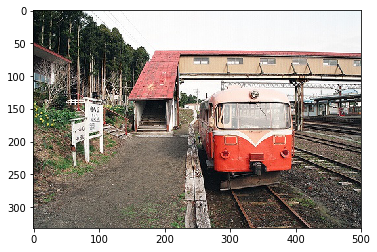

In [512]:
plt.imshow(batch_original_images[0])

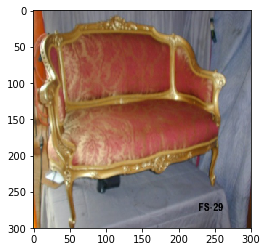

In [494]:
plt.imshow(batch_X[0])

In [340]:
batch_original_labels[0]

[[8, 57, 17, 500, 328]]

In [ ]:
add_col = np.insert(processed_label, [0], 32, axis=1); add_col

In [ ]:
og_label = batch_original_labels[0]; og_label

## Define Keras Callbacks

In [64]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, TensorBoard

In [65]:
def lr_schedule(epoch):
    if epoch < 120: 
        return 0.001
    elif epoch < 160:
        return 0.0001
    else:
        return 0.00001

In [66]:
#Define Model Callbacks
filepath = 'focalAugmented-ssd300_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1,
                                  save_best_only=True, save_weights_only=False, mode='auto',
                                  period=1)

csv_logger = CSVLogger(filename='ssd300_07_12_training_log2.csv', separator=',', append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)
terminate_on_nan = TerminateOnNaN()

tensorboard = TensorBoard(log_dir='./tensorboard4', histogram_freq=0, batch_size=batch_size, write_graph=True, write_images=True)
callbacks=[model_checkpoint, csv_logger, learning_rate_scheduler, terminate_on_nan, tensorboard]

In [67]:
steps_per_epoch = int(train_dataset.get_dataset_size()/ batch_size)
total_epochs = 20
initial_epoch = 0
steps_per_epoch_val = int(val_dataset.get_dataset_size()/ batch_size)

hist = md.fit_generator(generator=train_gen, 
                        steps_per_epoch=steps_per_epoch,
                        epochs=total_epochs, 
                        callbacks=callbacks,
                        validation_data=val_gen,
                        validation_steps=steps_per_epoch_val,
                        initial_epoch=initial_epoch,
                        verbose=1 )

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
517/517 [==============================] - 1368s 3s/step - loss: 39.8465 - val_loss: 30.2441

Epoch 00001: val_loss improved from inf to 30.24413, saving model to focalAugmented-ssd300_epoch-01_loss-39.9493_val_loss-30.2441.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
517/517 [==============================] - 1302s 3s/step - loss: 39.2874 - val_loss: 30.7208

Epoch 00002: val_loss did not improve from 30.24413
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
517/517 [==============================] - 1321s 3s/step - loss: 38.7632 - val_loss: 30.2642

Epoch 00003: val_loss did not improve from 30.24413
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
517/517 [==============================] - 1276s 2s/step - loss: 38.2046 - val_loss: 28.3365

Epoch 00004: val_loss improved from 30.24413 to 28.33648, saving mo

KeyboardInterrupt: 

In [ ]:
image, template = next(val_gen)

In [ ]:
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
limit_mem()

In [ ]:
def get_gradients(inputs, labels, model):
    opt = model.optimizer
    loss = model.total_loss
    weights = model.weights
    grads = opt.get_gradients(loss, weights)
    grad_fn = K.function(inputs=[model.inputs[0], 
                                 model.sample_weights[0],
                                 model.targets[0],
                                 K.learning_phase()], 
                         outputs=grads)
    grad_values = grad_fn([inputs, np.ones(len(inputs)), labels, 1])
    return grad_values

gradients = get_gradients(x, y, md)
for i in range(len(gradients)):
    #print("grad_{:d}".format(i), calc_stats(gradients[i]))
    print("grad_{:d}".format(i), gradients[i])
